<a href="https://colab.research.google.com/github/UNSW-ZZSC9020/project/blob/main/src/GoogleColab.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Welcome to ZZSC9020

This Python notebook shows how to clone the course GitHub repository on Google Colab.

You can develop your data analysis on Google Colab without downloading the data to your computer.

In [ ]:
# Import any packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Joint forecastdemand_nsw files into a single file. 
!cat data/NSW/forecastdemand_nsw.csv.zip.part* > data/NSW/forecastdemand_nsw.csv.zip

In [4]:
# Unzip the data files into the data folder
!unzip -o data/NSW/forecastdemand_nsw.csv.zip -d data/NSW
!unzip -o data/NSW/temperature_nsw.csv.zip -d data/NSW
!unzip -o data/NSW/totaldemand_nsw.csv.zip -d data/NSW

# Remove forecastdemand_nsw.csv.zip
!rm data/NSW/forecastdemand_nsw.csv.zip


216.55s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Archive:  data/NSW/forecastdemand_nsw.csv.zip
  inflating: data/NSW/forecastdemand_nsw.csv  


225.09s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Archive:  data/NSW/temperature_nsw.csv.zip
  inflating: data/NSW/temperature_nsw.csv  


230.44s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Archive:  data/NSW/totaldemand_nsw.csv.zip
  inflating: data/NSW/totaldemand_nsw.csv  


235.79s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [34]:
# inspect the forecastdemand_nsw.csv file
df_forecast = pd.read_csv('data/NSW/forecastdemand_nsw.csv')
print("Forecast Demand Data")
print(df_forecast.head())
print(df_forecast.info())

# inspect the temperature_nsw.csv file
df_temperature = pd.read_csv('data/NSW/temperature_nsw.csv')
print("Temperature Data")
print(df_temperature.head())
print(df_temperature.info())

# inspect the totaldemand_nsw.csv file
df_totaldemand = pd.read_csv('data/NSW/totaldemand_nsw.csv')
print("Total Demand Data")
print(df_totaldemand.head())
print(df_totaldemand.info())


Forecast Demand Data
   PREDISPATCHSEQNO REGIONID  PERIODID  FORECASTDEMAND          LASTCHANGED  \
0        2009123018     NSW1        71         7832.04  2009-12-30 12:31:49   
1        2009123019     NSW1        70         7832.04  2009-12-30 13:01:43   
2        2009123020     NSW1        69         7832.03  2009-12-30 13:31:36   
3        2009123021     NSW1        68         7832.03  2009-12-30 14:01:44   
4        2009123022     NSW1        67         7830.96  2009-12-30 14:31:35   

              DATETIME  
0  2010-01-01 00:00:00  
1  2010-01-01 00:00:00  
2  2010-01-01 00:00:00  
3  2010-01-01 00:00:00  
4  2010-01-01 00:00:00  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10906019 entries, 0 to 10906018
Data columns (total 6 columns):
 #   Column            Dtype  
---  ------            -----  
 0   PREDISPATCHSEQNO  int64  
 1   REGIONID          object 
 2   PERIODID          int64  
 3   FORECASTDEMAND    float64
 4   LASTCHANGED       object 
 5   DATETIME          

In [38]:
# Convert 'DATETIME' columns to datetime format (auto-infer format)
df_forecast['DATETIME'] = pd.to_datetime(df_forecast['DATETIME'], format='mixed', dayfirst=True, errors='coerce')
df_temperature['DATETIME'] = pd.to_datetime(df_temperature['DATETIME'], format='mixed', dayfirst=True, errors='coerce')
df_totaldemand['DATETIME'] = pd.to_datetime(df_totaldemand['DATETIME'], format='mixed', dayfirst=True, errors='coerce')

# Group by 'DATETIME' and calculate the mean of the 'FORECASTDEMAND' column
df_forecast_avg = df_forecast.groupby('DATETIME')['FORECASTDEMAND'].mean().reset_index()

# Display the result
print(df_forecast_avg.head())

             DATETIME  FORECASTDEMAND
0 2010-01-01 00:00:00     7824.411831
1 2010-01-01 00:30:00     7680.510417
2 2010-01-01 01:00:00     7428.971370
3 2010-01-01 01:30:00     7084.802162
4 2010-01-01 02:00:00     6751.369600


In [45]:
# Merge the first two DataFrames on 'DATETIME'
df_temp_forecast = pd.concat([df_forecast_avg, df_temperature], axis=1)

# Merge the above with the third DataFrame
df_merged = pd.concat([df_temp_forecast, df_totaldemand], axis=1)

# drop duplicate 'DATETIME' columns if any
df_merged = df_merged.loc[:,~df_merged.columns.duplicated()]
# drop unnecessary columns if any
df_merged = df_merged.drop(columns=['LOCATION', 'REGIONID'], errors='ignore')
df_merged['DEMAND_DIFF'] = (df_merged['FORECASTDEMAND'] - df_merged['TOTALDEMAND']).abs()
print(df_merged.head())

             DATETIME  FORECASTDEMAND  TEMPERATURE  TOTALDEMAND  DEMAND_DIFF
0 2010-01-01 00:00:00     7824.411831         23.1      8038.00   213.588169
1 2010-01-01 00:30:00     7680.510417         23.1      7809.31   128.799583
2 2010-01-01 01:00:00     7428.971370         22.9      7483.69    54.718630
3 2010-01-01 01:30:00     7084.802162         22.7      7117.23    32.427838
4 2010-01-01 02:00:00     6751.369600         22.6      6812.03    60.660400


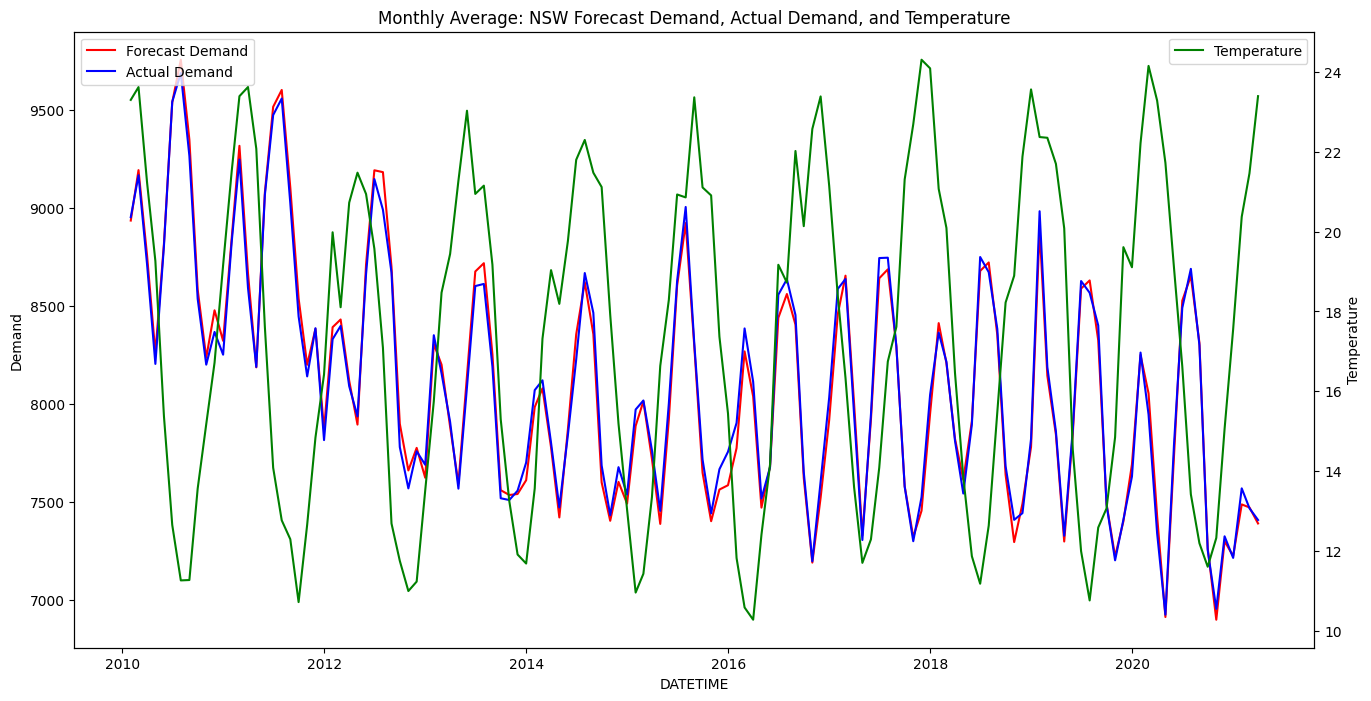

In [46]:
# Plot the merged DataFrame but resample to monthly averages for clarity
df_merged['DATETIME'] = pd.to_datetime(df_merged['DATETIME'], errors='coerce')
df_resampled = df_merged.set_index('DATETIME').resample('ME').mean(numeric_only=True).reset_index()

fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot Forecast and Actual Demand on the left y-axis
sns.lineplot(data=df_resampled, x='DATETIME', y='FORECASTDEMAND', label='Forecast Demand', color='red', ax=ax1)
sns.lineplot(data=df_resampled, x='DATETIME', y='TOTALDEMAND', label='Actual Demand', color='blue', ax=ax1)
ax1.set_ylabel('Demand')
ax1.legend(loc='upper left')

# Create a second y-axis for Temperature
ax2 = ax1.twinx()
sns.lineplot(data=df_resampled, x='DATETIME', y='TEMPERATURE', label='Temperature', color='green', ax=ax2)
ax2.set_ylabel('Temperature')
ax2.legend(loc='upper right')

plt.title('Monthly Average: NSW Forecast Demand, Actual Demand, and Temperature')
plt.xlabel('Datetime')
plt.show()

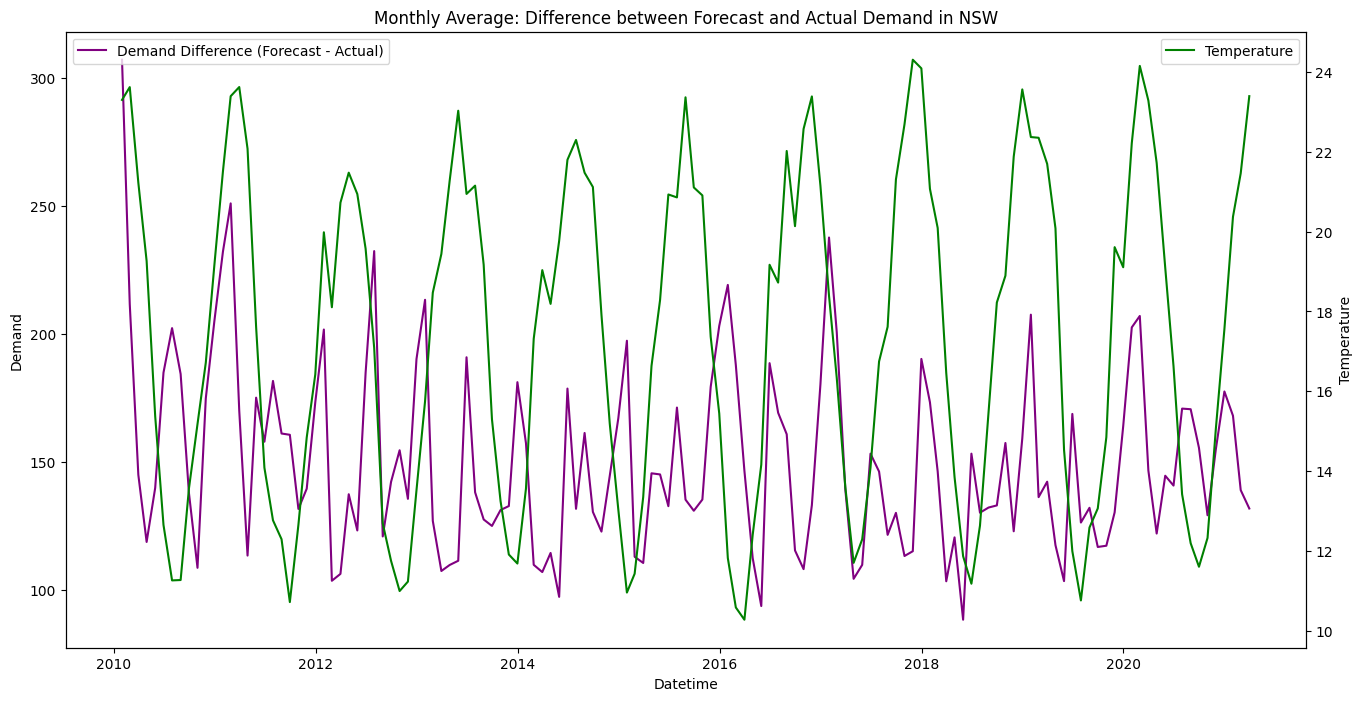

In [47]:
# Plotting the same but the difference between Forecast and Actual Demand
fig, ax1 = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df_resampled, x='DATETIME', y='DEMAND_DIFF', label='Demand Difference (Forecast - Actual)', color='purple', ax=ax1)
plt.xlabel('Datetime')
ax1.set_ylabel('Demand')
ax1.legend(loc='upper left')

# Create a second y-axis for Temperature
ax2 = ax1.twinx()
sns.lineplot(data=df_resampled, x='DATETIME', y='TEMPERATURE', label='Temperature', color='green', ax=ax2)
ax2.set_ylabel('Temperature')
ax2.legend(loc='upper right')

plt.title('Monthly Average: Difference between Forecast and Actual Demand in NSW')
plt.xlabel('Datetime')
plt.show()

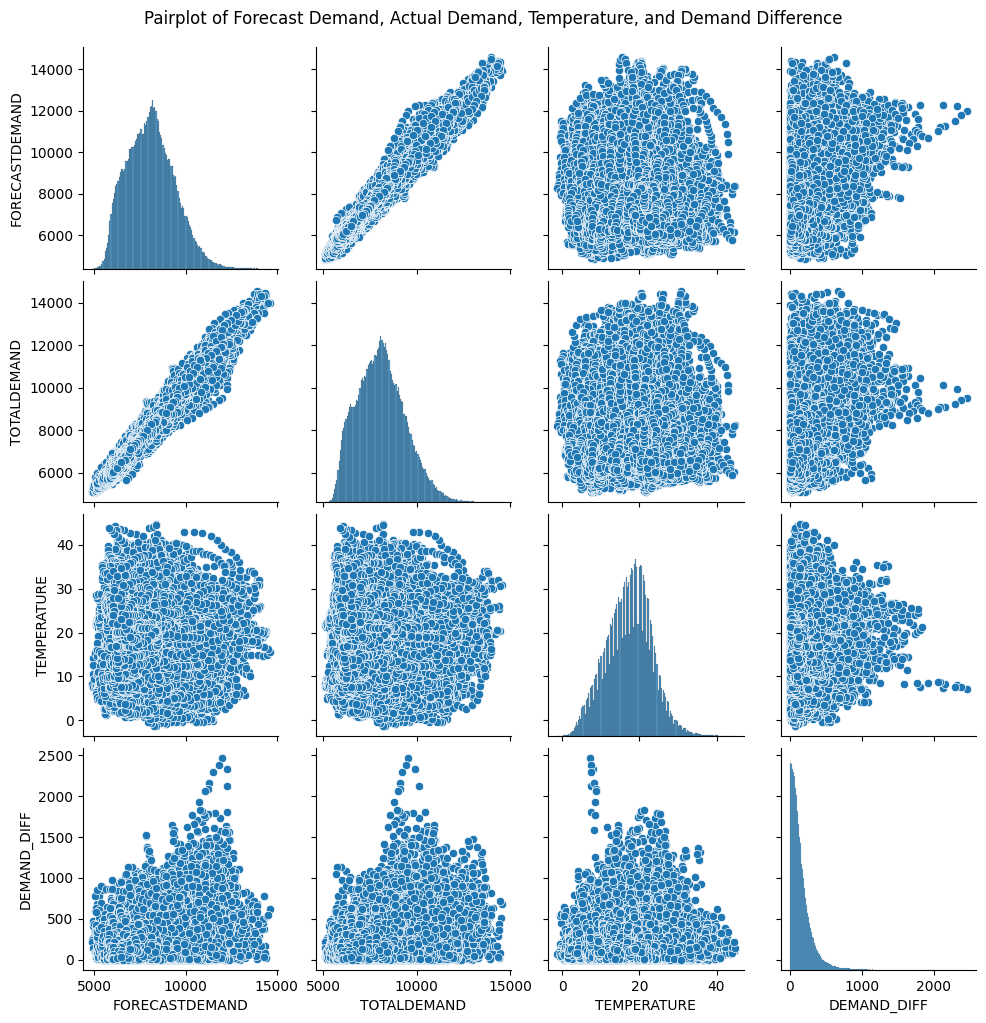

In [48]:
# pairplot of the numeric columns
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the relevant numeric columns for the pairplot
pairplot_cols = ['FORECASTDEMAND', 'TOTALDEMAND', 'TEMPERATURE', 'DEMAND_DIFF']
sns.pairplot(df_merged[pairplot_cols].dropna())
plt.suptitle('Pairplot of Forecast Demand, Actual Demand, Temperature, and Demand Difference', y=1.02)
plt.show()

In [49]:

# Define extreme temperature thresholds (e.g., top/bottom 10%)
high_temp = df_merged['TEMPERATURE'].quantile(0.90)
low_temp = df_merged['TEMPERATURE'].quantile(0.10)

# Stratify data
extreme_days = df_merged[(df_merged['TEMPERATURE'] >= high_temp) | (df_merged['TEMPERATURE'] <= low_temp)]
normal_days = df_merged[(df_merged['TEMPERATURE'] < high_temp) & (df_merged['TEMPERATURE'] > low_temp)]

# Compare mean absolute error
print("Mean Absolute Error on Extreme Temperature Days:", extreme_days['DEMAND_DIFF'].mean())
print("Mean Absolute Error on Normal Temperature Days:", normal_days['DEMAND_DIFF'].mean())

Mean Absolute Error on Extreme Temperature Days: 154.55506422040514
Mean Absolute Error on Normal Temperature Days: 149.61165930213912


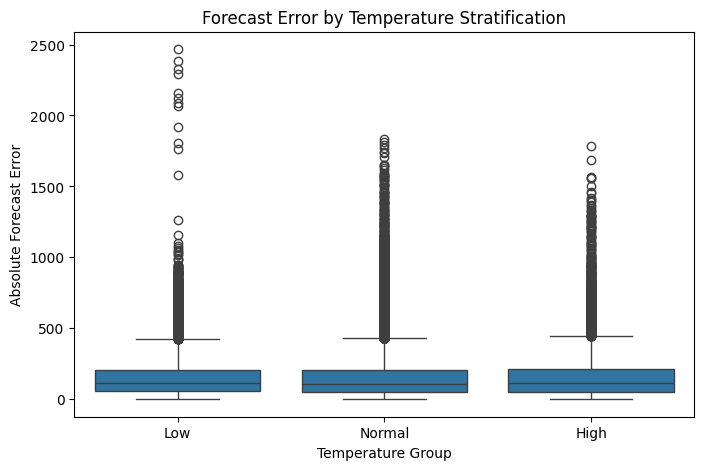

In [50]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_merged, x=pd.cut(df_merged['TEMPERATURE'], 
    bins=[-float('inf'), low_temp, high_temp, float('inf')], 
    labels=['Low', 'Normal', 'High']), y='DEMAND_DIFF')
plt.title('Forecast Error by Temperature Stratification')
plt.xlabel('Temperature Group')
plt.ylabel('Absolute Forecast Error')
plt.show()

In [51]:
# Lastly delete the unzipped files to save space
!rm data/NSW/forecastdemand_nsw.csv
!rm data/NSW/temperature_nsw.csv
!rm data/NSW/totaldemand_nsw.csv

2646.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2651.89s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
2657.26s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
